In [11]:
%load_ext autoreload
%autoreload 2

import os
import random
import time
import numpy as np
import logging
import argparse
from collections import *

import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from model.pspnet import PSPNet
from util import dataset, transform, config
from util.util import AverageMeter, poly_learning_rate, intersectionAndUnionGPU


args = config.load_cfg_from_cfg_file("config/nyu_pspnet18.yaml")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
split = "train"

value_scale = 255
mean = [0.485, 0.456, 0.406]
mean = [item * value_scale for item in mean]
std = [0.229, 0.224, 0.225]
std = [item * value_scale for item in std]

val_transform = transform.Compose([
            transform.Resize((473, 473)),
            transform.ToTensor(),
            transform.Normalize(mean=mean, std=std)
])

val_data = dataset.SemData(split=split, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=False,
                                         num_workers=args.workers, pin_memory=True, sampler=None)



criterion = nn.CrossEntropyLoss(ignore_index=args.ignore_label)
model = PSPNet(layers=args.layers, classes=args.classes,
               zoom_factor=args.zoom_factor,
               criterion=criterion)



Totally 381 samples in train set.
Starting Checking image&label pair train list...
Checking image&label pair train list done!


In [17]:
args.weight = "/root/projects/cv_hw/semseg/exp/nyu/pspnet18_trainval/model/train_epoch_50.pth"
checkpoint = torch.load(args.weight)
model.load_state_dict(checkpoint['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [18]:
model = model.cuda()
model = model.eval()


In [19]:
outputs = []
loss = []
images = []

loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()


scale = 1.0

for image, label in tqdm(val_loader):

    image = image.cuda()
    label = label.cuda()
    with torch.no_grad():
        output_logit = model(image, label)
    if args.zoom_factor != 8:
        output_logit = F.interpolate(output_logit, size=label.size()[1:], mode='bilinear', align_corners=True)

    loss = criterion(output_logit, label)
    output = output_logit.max(1)[1]
    outputs.append(output.cpu())

    intersec_pixel_num, \
    union_pixel_num, \
    label_pixel_num = intersectionAndUnionGPU(output, label, 
                                              args.classes, args.ignore_label,
                                              to_cpu=True, to_numpy=True)

    intersection_meter.update(intersec_pixel_num)
    union_meter.update(union_pixel_num)
    target_meter.update(label_pixel_num)



100%|██████████| 48/48 [00:15<00:00,  4.01it/s]


In [20]:
names = [line.rstrip('\n') for line in open("/root/projects/cv_hw/semseg/data/nyud/data_list/classes.txt")]
# acc of each batch
iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
accuracy_class = intersection_meter.sum / (target_meter.sum + 1e-10)
mIoU = np.mean(iou_class)
mAcc = np.mean(accuracy_class)
allAcc = sum(intersection_meter.sum) / (sum(target_meter.sum) + 1e-10)
print('Eval result: mIoU/mAcc/allAcc {:.4f}/{:.4f}/{:.4f}.'.format(mIoU, mAcc, allAcc))
for i in range(union_pixel_num.shape[0]):
    print('Class_{} result: iou/accuracy {:.4f}/{:.4f}, name: {}.'.format(i, iou_class[i], accuracy_class[i],
                                                                                names[i-1]))
outputs = torch.cat(outputs).cpu()


Eval result: mIoU/mAcc/allAcc 0.6249/0.7720/0.7981.
Class_0 result: iou/accuracy 0.3038/0.4142, name: otherprop.
Class_1 result: iou/accuracy 0.7678/0.8848, name: wall.
Class_2 result: iou/accuracy 0.8467/0.9186, name: floor.
Class_3 result: iou/accuracy 0.7808/0.8901, name: cabinet.
Class_4 result: iou/accuracy 0.8492/0.9462, name: bed.
Class_5 result: iou/accuracy 0.6085/0.7518, name: chair.
Class_6 result: iou/accuracy 0.7713/0.9434, name: sofa.
Class_7 result: iou/accuracy 0.5717/0.7215, name: table.
Class_8 result: iou/accuracy 0.5870/0.7196, name: door.
Class_9 result: iou/accuracy 0.6880/0.8283, name: window.
Class_10 result: iou/accuracy 0.6143/0.8411, name: bookshelf.
Class_11 result: iou/accuracy 0.6601/0.7567, name: picture.
Class_12 result: iou/accuracy 0.7161/0.8467, name: counter.
Class_13 result: iou/accuracy 0.7715/0.9506, name: blinds.
Class_14 result: iou/accuracy 0.6446/0.8259, name: desk.
Class_15 result: iou/accuracy 0.5363/0.7147, name: shelves.
Class_16 result: i

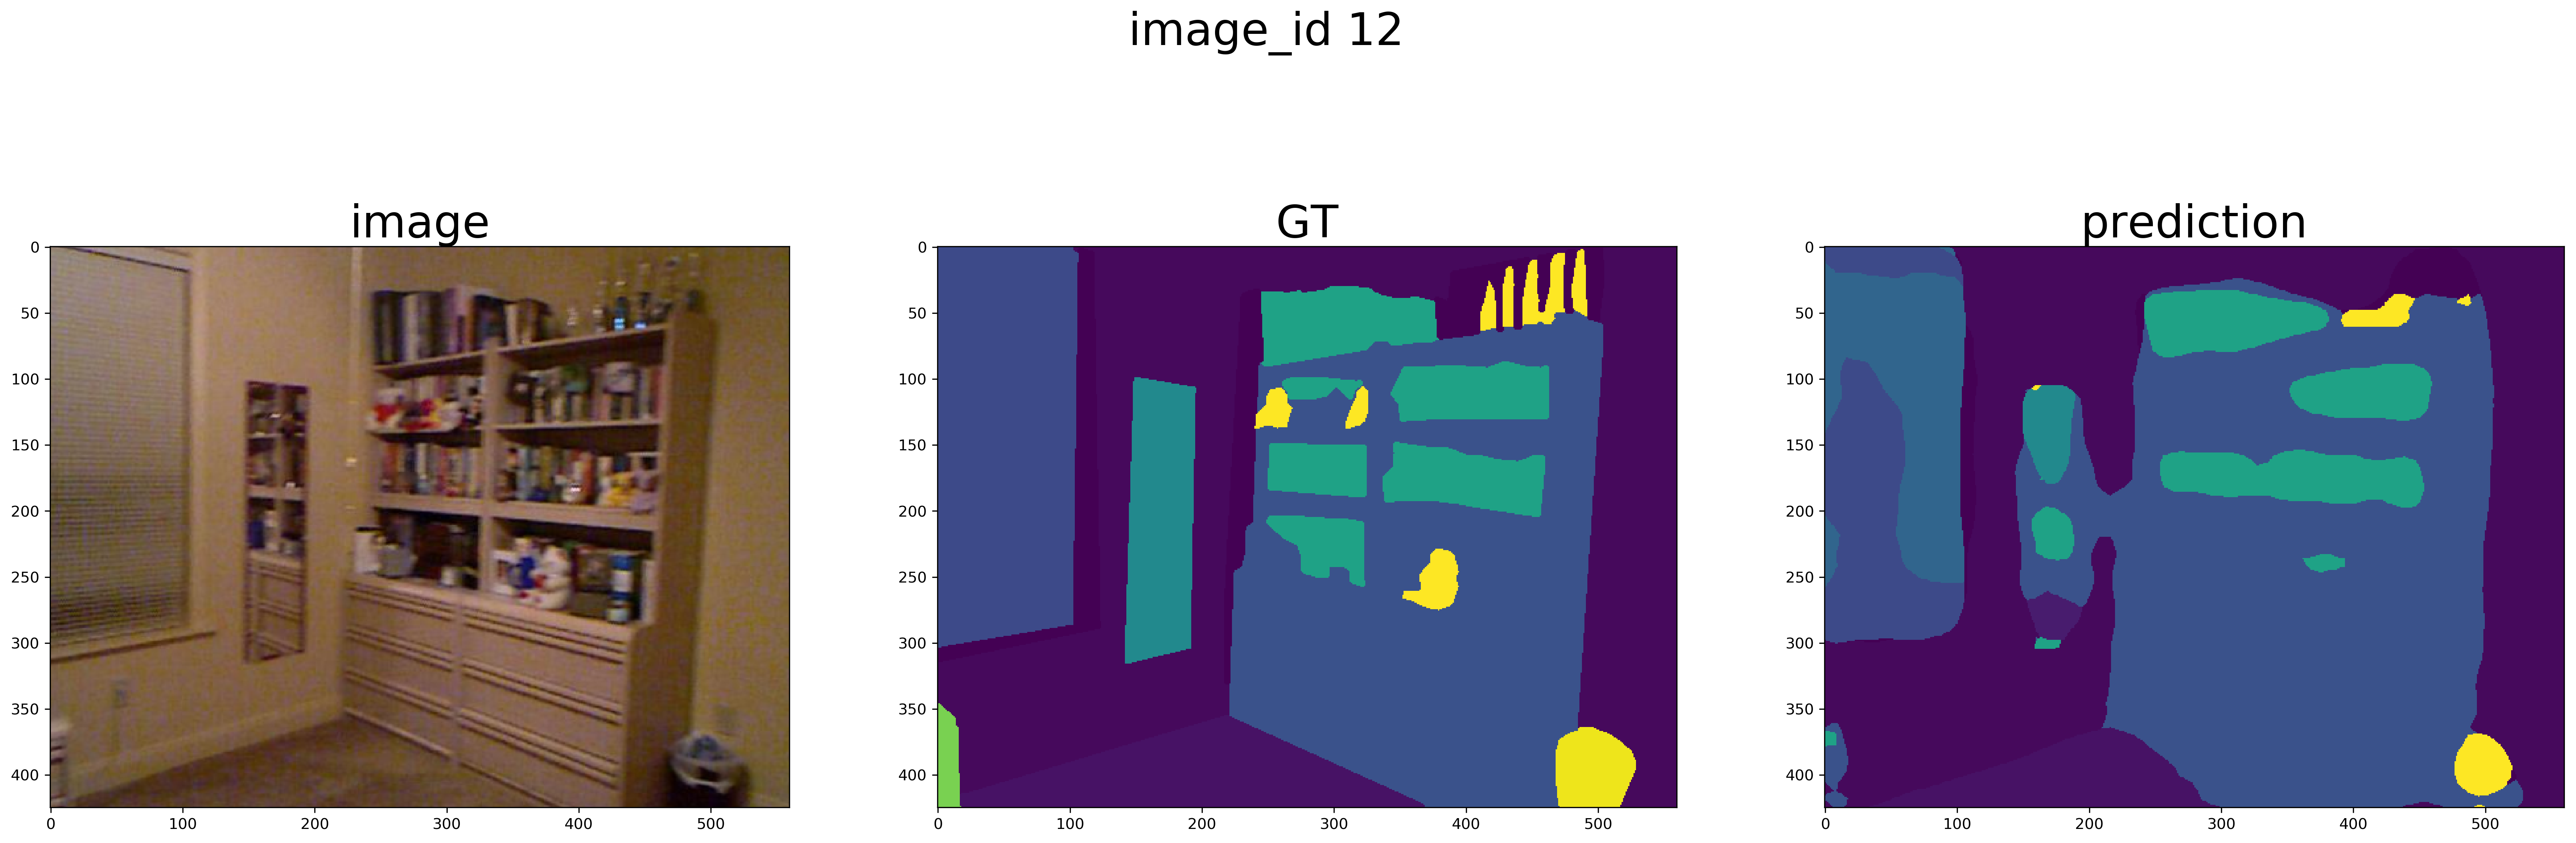

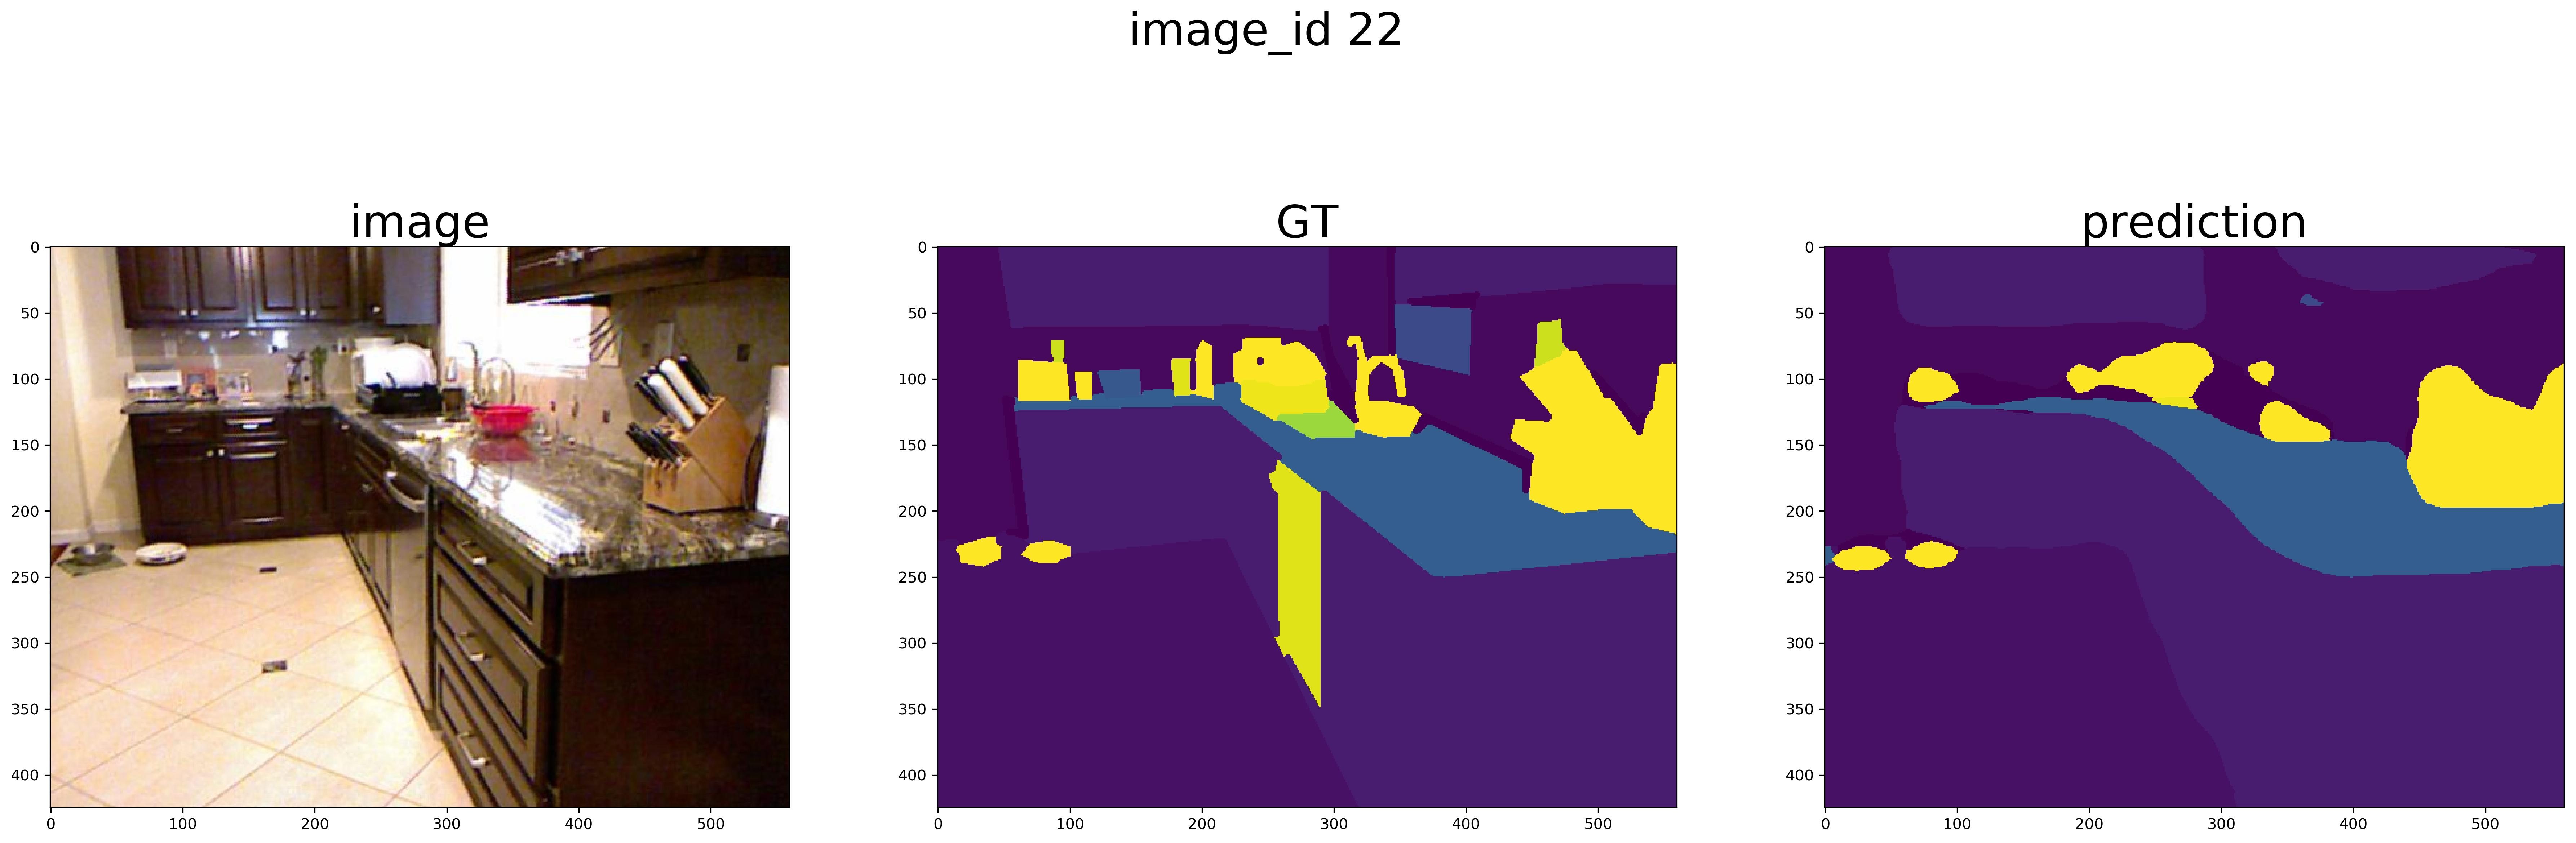

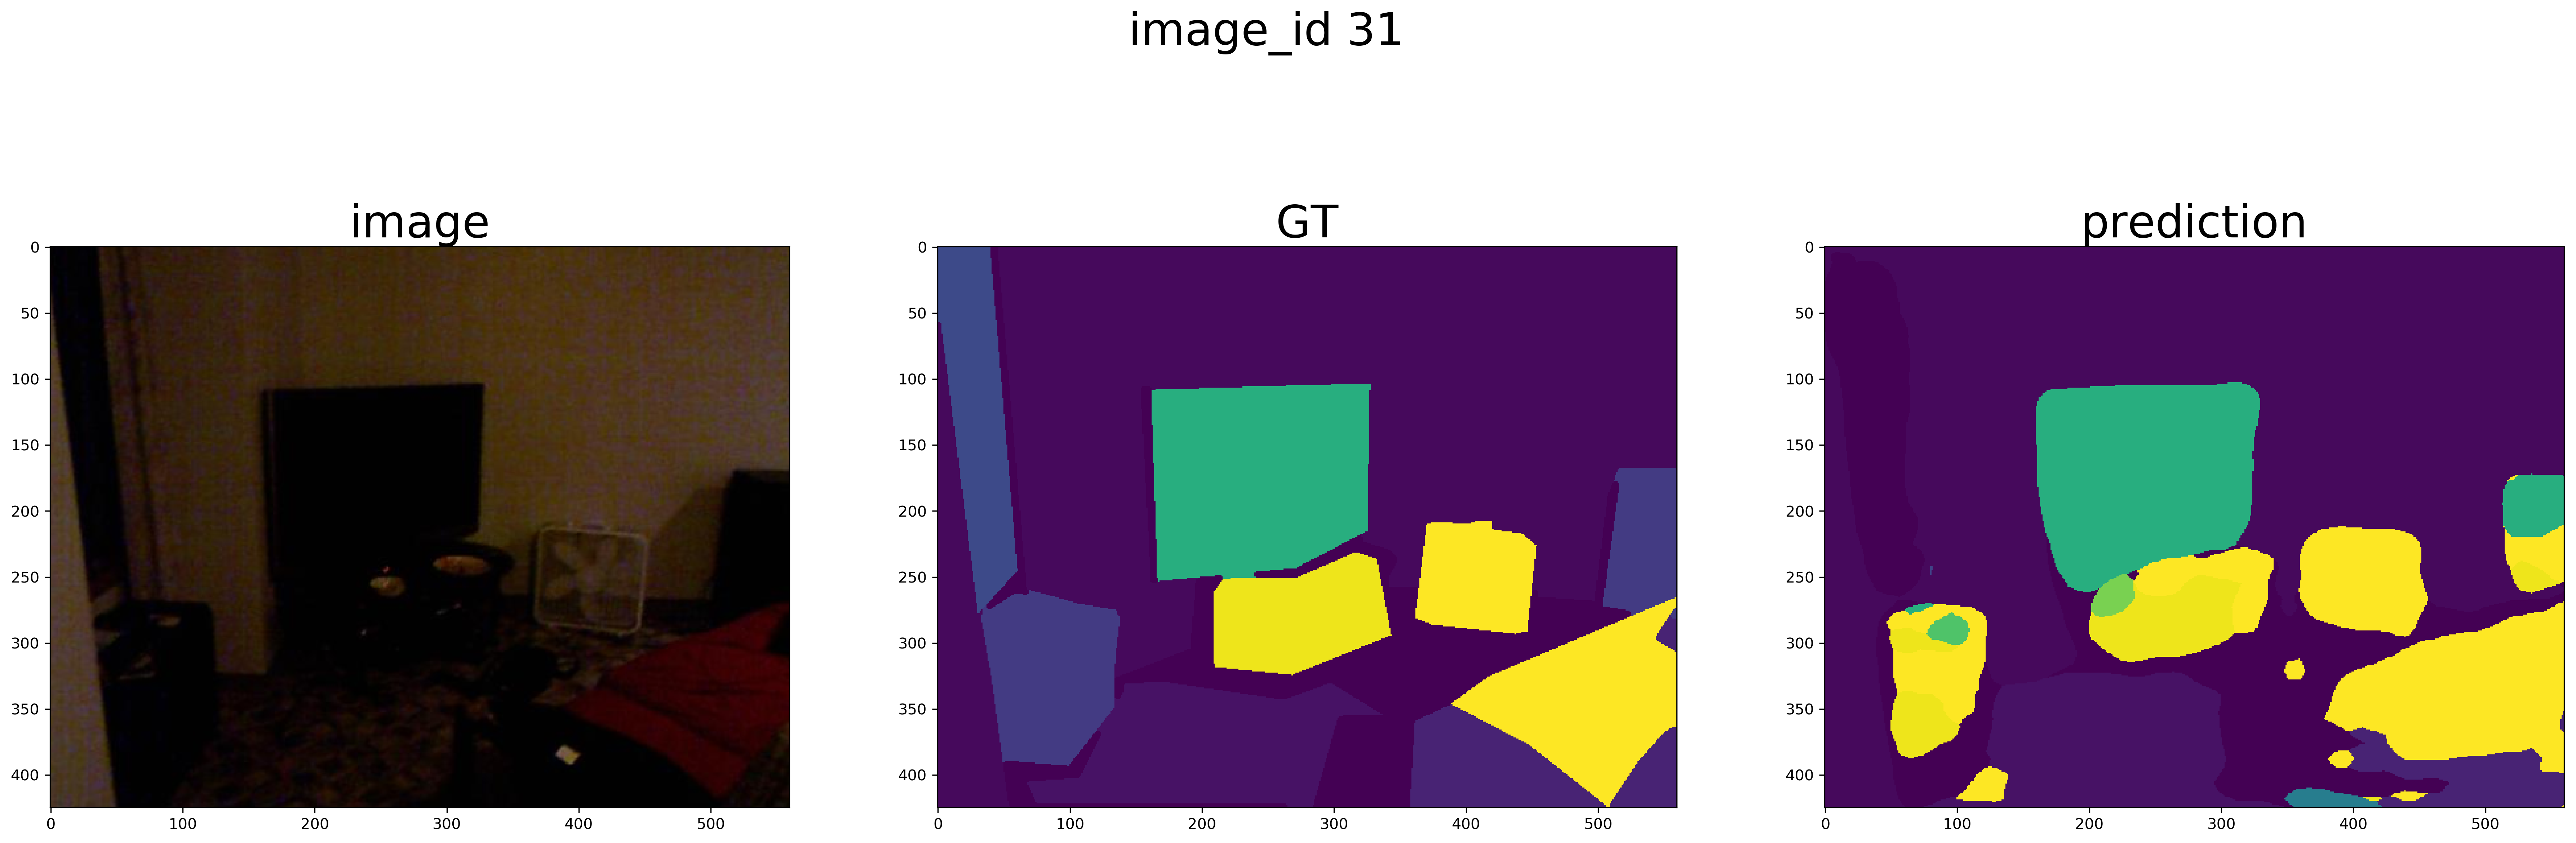

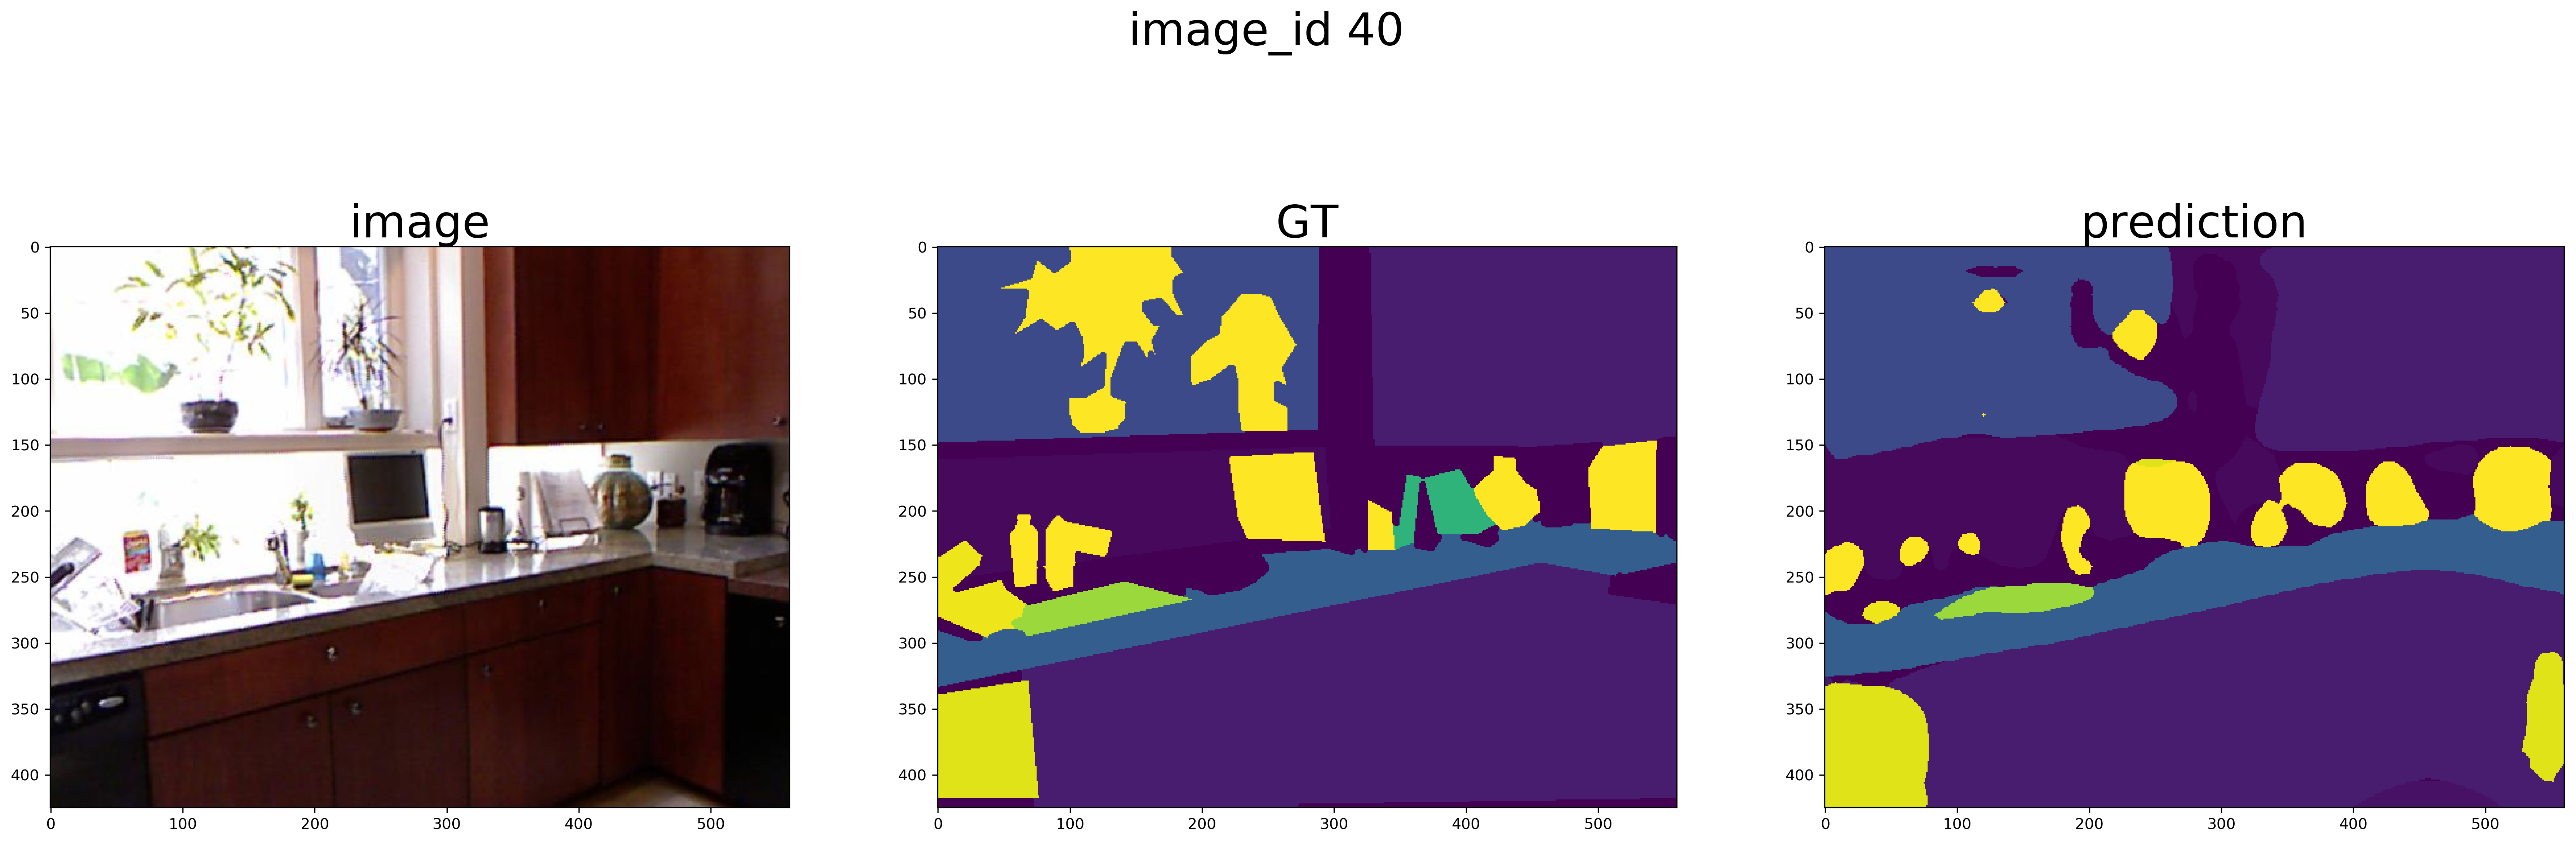

In [24]:
vis_data = dataset.SemData(split=split, transform=None)
plt.rcParams['figure.dpi'] = 300 
colors = np.loadtxt("config/nyu_colors.txt").astype('uint8')
from PIL import Image
def colorize(gray, palette):
    # gray: numpy array of the label and 1*3N size list palette
    color = Image.fromarray(gray.astype(np.uint8)).convert('P')
    color.putpalette(palette)
    return color


def show_result(data_idx):
    init_image, init_label = vis_data[data_idx]
    
    init_label = np.uint8(init_label)
    init_image = np.uint8(init_image)
    color = colorize(init_label, colors)
    fig, ax = plt.subplots(1, 3, figsize=(30,10))
    fig.suptitle("image_id %d" % (data_idx), fontsize=30)
    fig.set_facecolor((1,1,1))
    ax[0].imshow(init_image)
    ax[0].set_title("image", fontsize=30)
    ax[1].imshow(init_label)
    ax[1].set_title("GT", fontsize=30)
    
    pred_label = np.uint8(outputs[data_idx])
    pred_label_color = colorize(pred_label, colors)
    pred_label_color = pred_label_color.resize(init_label.shape[::-1])
    ax[2].imshow(pred_label_color)
    ax[2].set_title("prediction", fontsize=30)
    plt.show()
    
show_result(12)
show_result(22)
show_result(31)
show_result(40)